## DMS Barcode Resampling Simulation Prototype

0. [Core Conclusions](#part0)
1. [Background](#part1)
2. [Data Subset](#part2)
3. [Sampling Across Clones and Replicates](#part3)
4. [Downsampling Results and Interpretation](#part4)

### Core Conclusions <a name="part0"></a>

NOTE: An important caveat is that the following analysis considers only all barcodes from the TYK2 chunk 10 assay that are either WT or contain a variant at position 638. This analysis could be expanded to all positions and variants.

- We observe that relative library composition at the variant level remains relatively constant throughout various stages in the process.
    -  For example, variants that are 10X more abundant than the rest of the library at the chip design stage are 10X more abundant at the barcode mapping _and_ barcode expression stages.
-  A large majority of mapped barcodes are "lost" between mapping and expression, presumably during integration.
-  Most barcodes in each RNA sample are detected in more than one replicate, and a defined subset of barcodes is specific to each clone. Clone 1 has more clone-specific barcodes than Clone 8, which likely explains its slightly increased power.
-  Resampling of expression counts under all weighting schemes demonstrates a straightforward tradeoff between barcodes per variant and power very similar to that observed previously with MC4R.

### Background <a name="part1"></a>

In the initial TYK2 DMS across chunk 10, two clone pools were generated after barcode mapping from the same library (named c1 and c8). After creation and expansion, they are frozen down, stored, and re-expanded in triplicate for the barcode expression component of the experiment. The schematic below depicts this procedure:

In [4]:
library(png)
library(GGally)
library(scales)
library(UpSetR)
library(hexbin)
library(patchwork)
library(ggbeeswarm)
library(fs)
library(parallel)
library(broom.mixed)
library(glmmTMB)
library(data.table)
library(tidyverse)

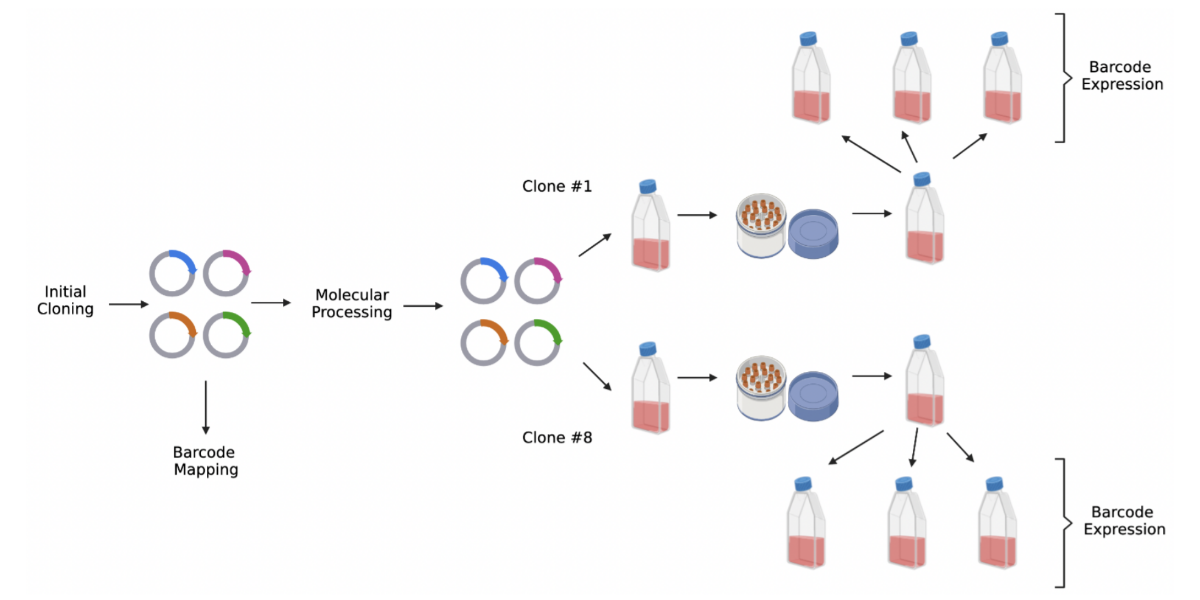

In [4]:
options(repr.plot.width = 10, repr.plot.height = 5)
img <- readPNG("experimental-schematic.png")
grid::grid.raster(img)

There are several points at which we sample a subpopulation of variants from a larger group. However, we have two readouts - the barcode mapping procedure and the barcode expression assay. While barcode mapping provides some quantitative information about barcode abundance (e.g. the number of reads for each barcode), it is primarily used for determining barcode-oligo associations. The molecular processing and storage after barcode mapping may change barcode frequencies relative to those displayed during barcode mapping, and thus read counts at barcode mapping may not provide quantitative information about sampling probabilities.

### Data Subset <a name="part2"></a>

The "unit of regression" in DMS analysis includes all wild-type barcodes and all barcodes mapped to a variant at a specific, individual position. With the benefit of our spike-ins, we can choose a position with an enriched variant to capture resampling effects at different scales. We select position 638, which includes the enriched stop variant 638X. Retrieving all barcodes in either barcode mapping or in barcode expression corresponding to WT or 638-MUT constructs returns a tractable dataset for resampling:

- 475102 barcodes identified during barcode mapping
- 62244 out of 475102 barcodes were detected in at least one replicate during barcode expression

In [10]:
bcs_filt <- fread("../pipeline/batch1-renamed/10.bcmap-final.tsv", header = T) %>%
    separate(oligo, c("lib", "chunk", "wt_aa", "pos",
        "mut_aa", "wt_codon", "mut_codon"), "_")

bcs_filt$mut_aa[which(bcs_filt$wt_aa == bcs_filt$mut_aa | is.na(bcs_filt$mut_aa))] <- "WT" #nolint
bcs_filt$mut_aa <- relevel(as.factor(bcs_filt$mut_aa), ref = "WT")

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 364629 rows [35, 48, 79, 97, 98, 100, 105, 139, 141, 142, 157, 169, 189, 227, 299, 318, 334, 345, 348, 376, ...].”


In [5]:
mapped_counts <- fread("../pipeline/batch1-renamed/10.mapped-counts.tsv") %>%
    separate(oligo, c("lib", "chunk", "wt_aa", "pos",
        "mut_aa", "wt_codon", "mut_codon"), "_") %>%
    group_by(sample) %>%
    mutate(total_counts = sum(count[which(mut_aa == "*")]) / 1000000)

mapped_counts$mut_aa[which(mapped_counts$wt_aa == mapped_counts$mut_aa | is.na(mapped_counts$mut_aa))] <- "WT" #nolint
mapped_counts$mut_aa <- relevel(as.factor(mapped_counts$mut_aa), ref = "WT")
mapped_counts$condition <- relevel(as.factor(mapped_counts$condition), ref = "none")

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 287883 rows [8, 66, 71, 84, 99, 133, 136, 140, 184, 198, 206, 234, 235, 239, 263, 266, 271, 273, 301, 304, ...].”


In [11]:
test638_counts <- mapped_counts %>% filter(pos == 638 | wt_aa == mut_aa, grepl("1|2",sample))
test638_bcmap <- bcs_filt %>% filter(pos == 638 | wt_aa == mut_aa)

write_tsv(test638_counts, "../pipeline/resampling-counts.tsv")
write_tsv(test638_bcmap, "../pipeline/resampling-bcs.tsv")

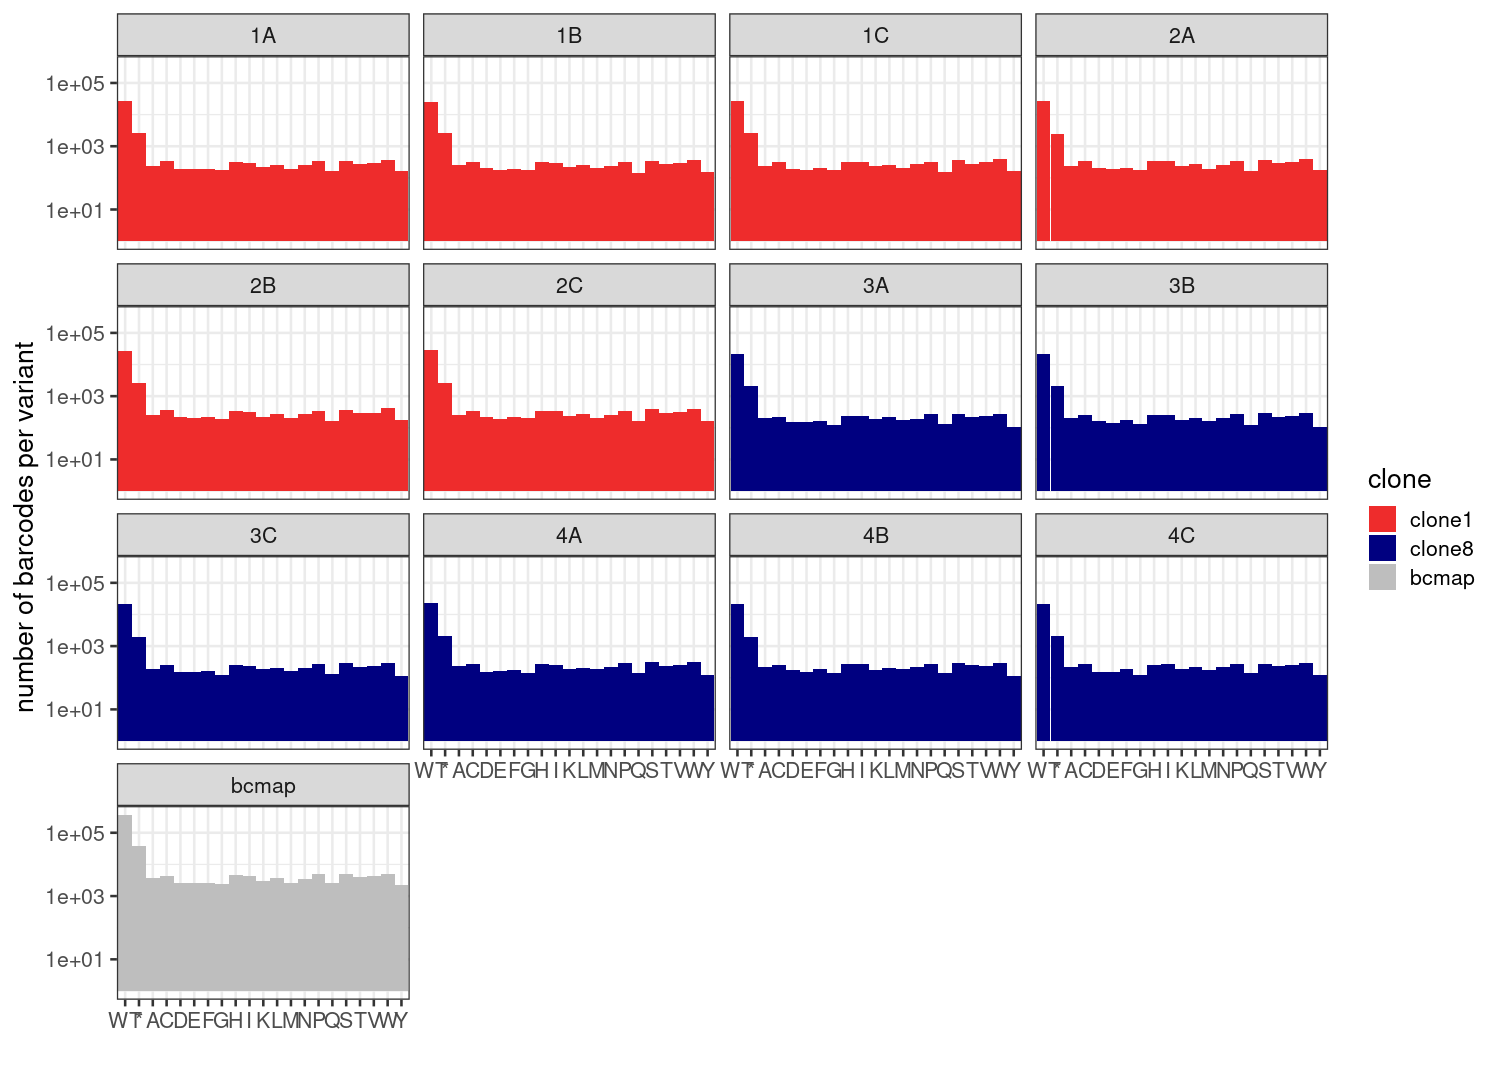

In [56]:
options(repr.plot.width = 12.5, repr.plot.height = 9) 

test638_counts <- mapped_counts %>% filter(pos == 638 | wt_aa == mut_aa)

bar_data <- test638_counts %>% 
    select(barcode, mut_aa, sample) %>%
    bind_rows(test638_bcmap %>%
              select(bc, mut_aa) %>%
              mutate(sample = "bcmap") %>%
              rename("barcode" = "bc")) %>%
    mutate(clone = if_else(grepl("1|2",sample), "clone1", "clone8")) %>%
    count(mut_aa, clone) %>%
    mutate(clone = if_else(sample == "bcmap", "bcmap", clone))

ggplot(bar_data) + 
    geom_bar(aes(x = mut_aa, y = n, fill = clone), width = 1, stat = "identity") +
    facet_wrap(~sample) +
    scale_y_log10() +
    theme_bw(base_size = 16) +
    xlab("") + ylab("number of barcodes per variant") +
    scale_fill_manual(values = c("clone1" = "firebrick2",
                                 "clone8" = "navyblue",
                                 "bcmap" = "gray"))

These look pretty well correlated, both across replicates and between the barcode map and the replicates. These are small sets of values so we can compute the correlation matrix easily:

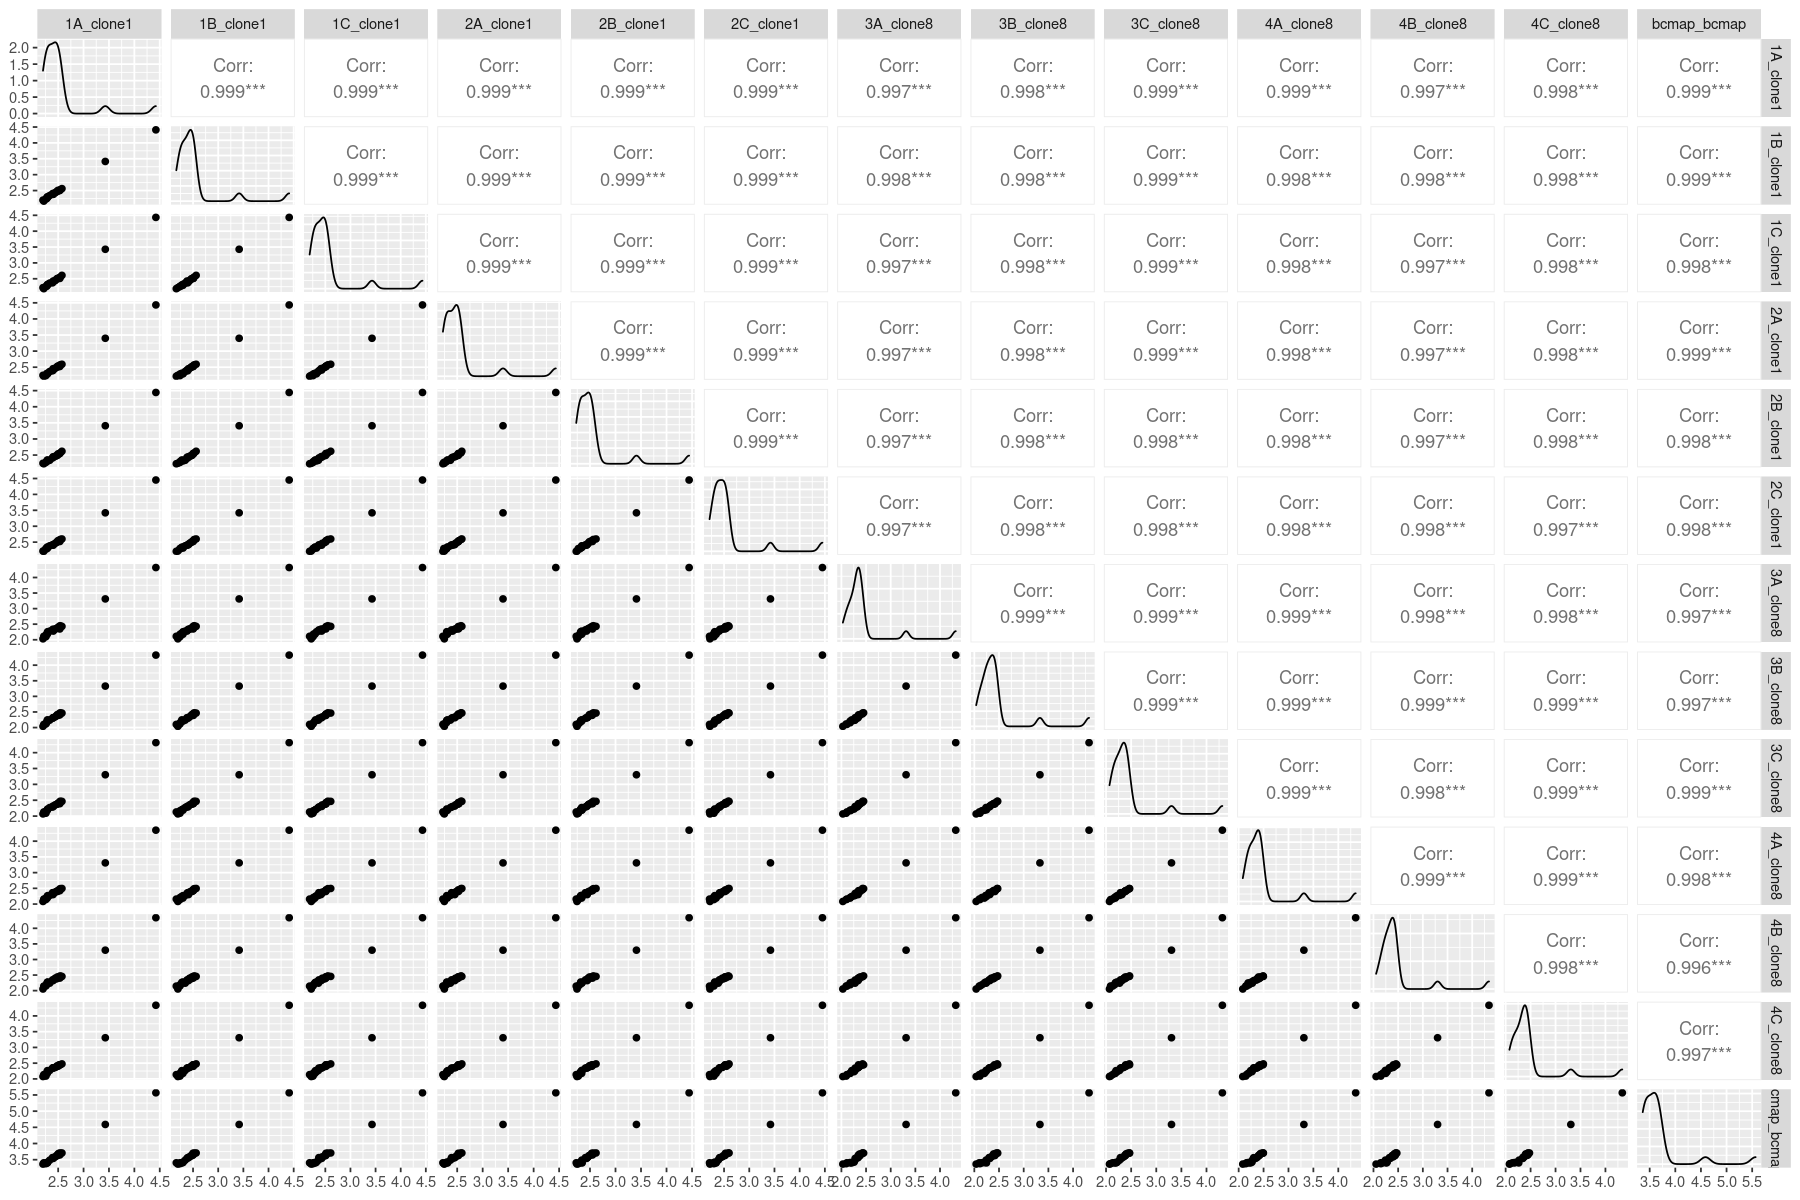

In [54]:
cor_data <- bar_data %>%
    mutate(n = log10(n),
           sample = paste0(sample, "_", clone)) %>%
    select(-clone) %>%
    pivot_wider(names_from = sample,
                values_from = n,
                values_fill = 0) %>%
    select(-mut_aa)

options(repr.plot.width = 15, repr.plot.height = 10)
ggpairs(cor_data)

The barcodes detected per residue are remarkably consistent. There are two clearly outlying points though, which are the WT barcodes and 638X barcodes. We can remove those and plot this again to get a clearer view, and also to double check that these values are indeed different across samples:

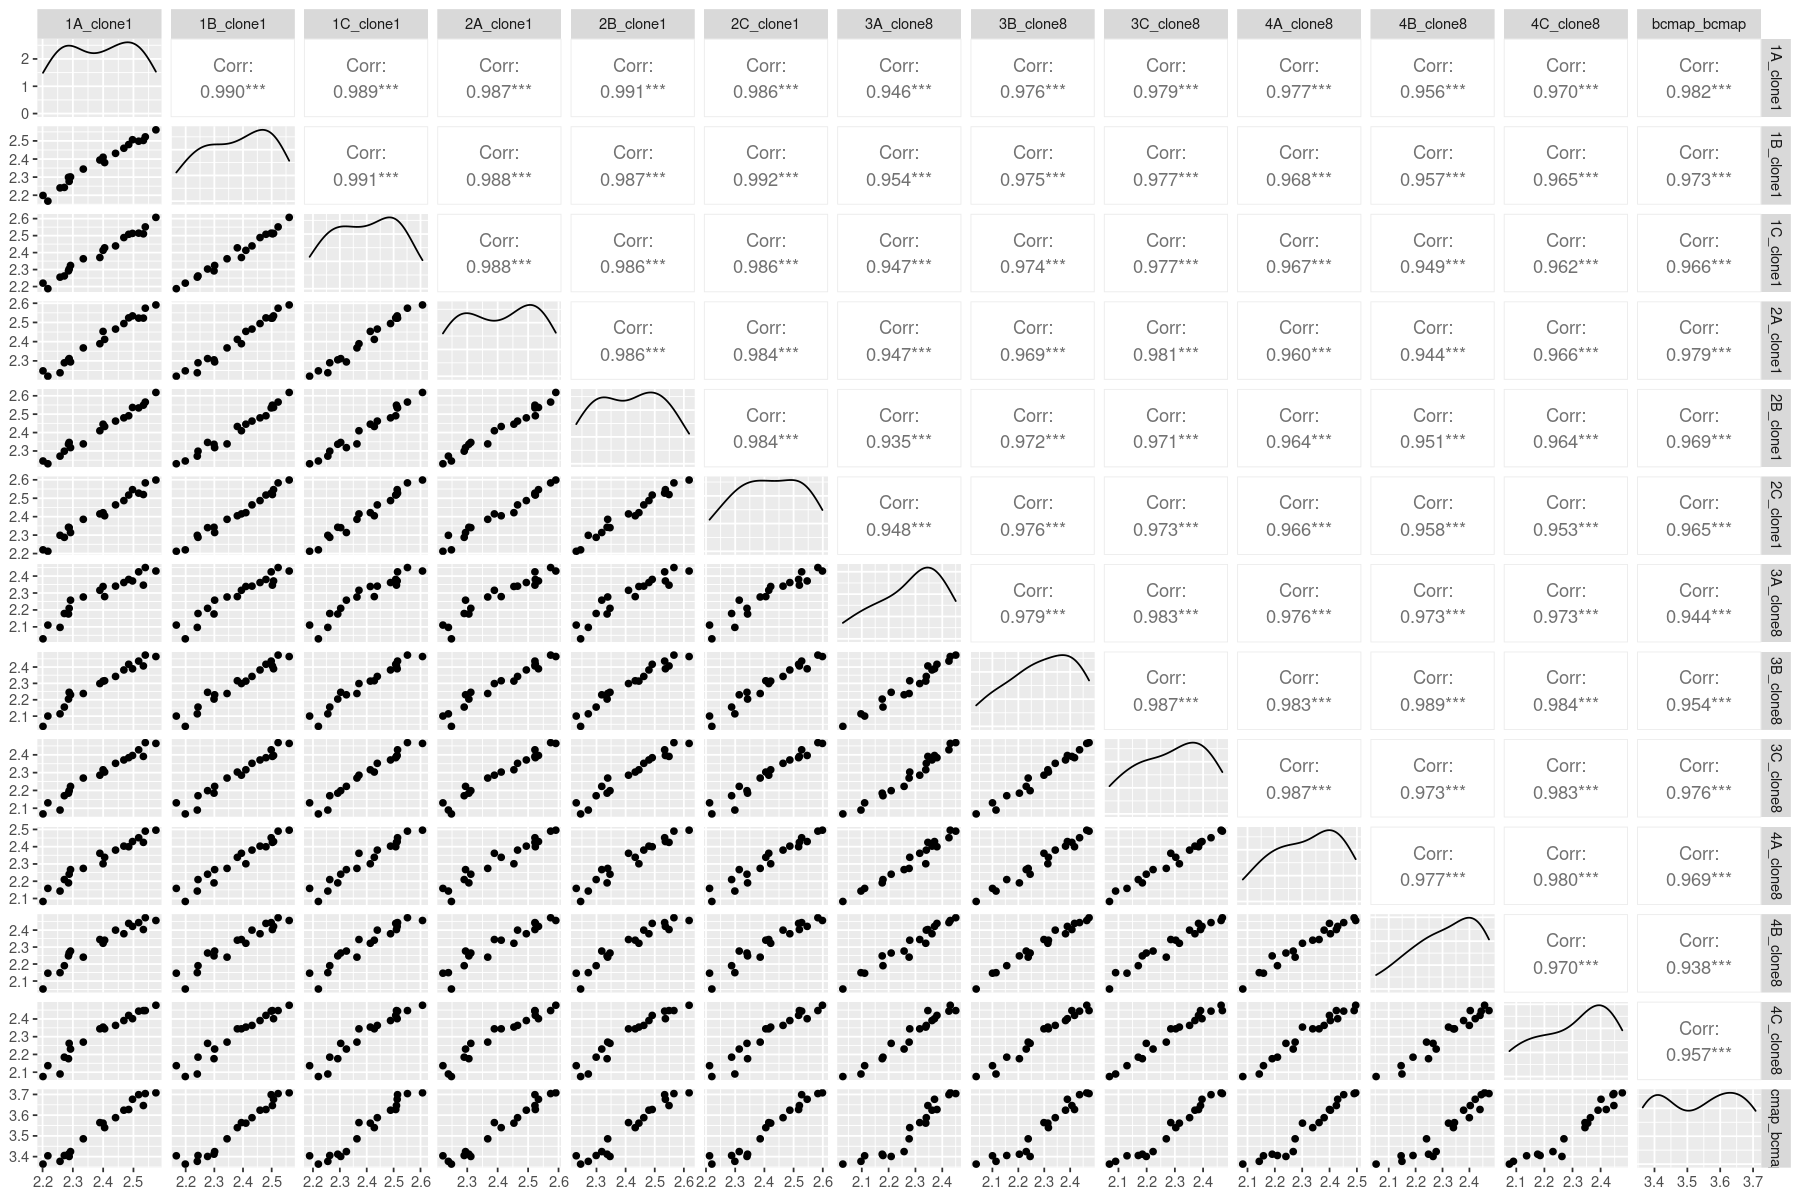

In [55]:
cor_data <- bar_data %>%
    filter(mut_aa != "WT", mut_aa != "*") %>%
    mutate(n = log10(n),
           sample = paste0(sample, "_", clone)) %>%
    select(-clone) %>%
    pivot_wider(names_from = sample,
                values_from = n,
                values_fill = 0) %>%
    select(-mut_aa)

options(repr.plot.width = 15, repr.plot.height = 10)
ggpairs(cor_data)

We could imagine subsampling either the barcode map (followed by removing and counts from barcode expression which were from a removed barcode) or the barcode expression data. Given the ambiguity about the extent to which barcode counts in barcode mapping are quantitatively useful, we start by simply subsampling barcodes from each of the three replicates of clone 1. We can do this either in a _weighted_ manner, where the read counts themselves provide the relative probability of selection, or _unweighted_ where those probabilities are all equal.

### Sampling Across Clones and Replicates <a name="part3"></a>

Above, we describe the numbers of barcodes per variant at this position compared to WT. However, we can more directly examing the overlap of barcodes between each sample and the barcode map using an upset plot. To see how to interpret these plots, lets make one of these plots that includes just three replicates from clone 1:

In [58]:
bcs <- read_tsv("../pipeline/resampling-bcs.tsv") %>%
    group_by(bc) %>%
    filter(n() == 1)
counts <- read_tsv("../pipeline/resampling-counts.tsv")

Rows: 475732 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): bc, lib, wt_aa, mut_aa, wt_codon, mut_codon
dbl (2): chunk, pos


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 208151 Columns: 15

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, condition...
dbl (6): count, chunk, pos, dox, condition_conc, total_counts


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [59]:
counts_allrna <- mapped_counts %>% filter(pos == 638 | wt_aa == mut_aa)
bcs_set <- tibble("barcode" = bcs$bc,
                  "sample" = "bcmap")

bc_nest <- counts_allrna %>%
    select(barcode, sample) %>%
    bind_rows(bcs_set) %>%
    group_by(sample) %>%
    summarize(bcs = list(barcode))

upset_input <- bc_nest$bcs
names(upset_input) <- bc_nest$sample

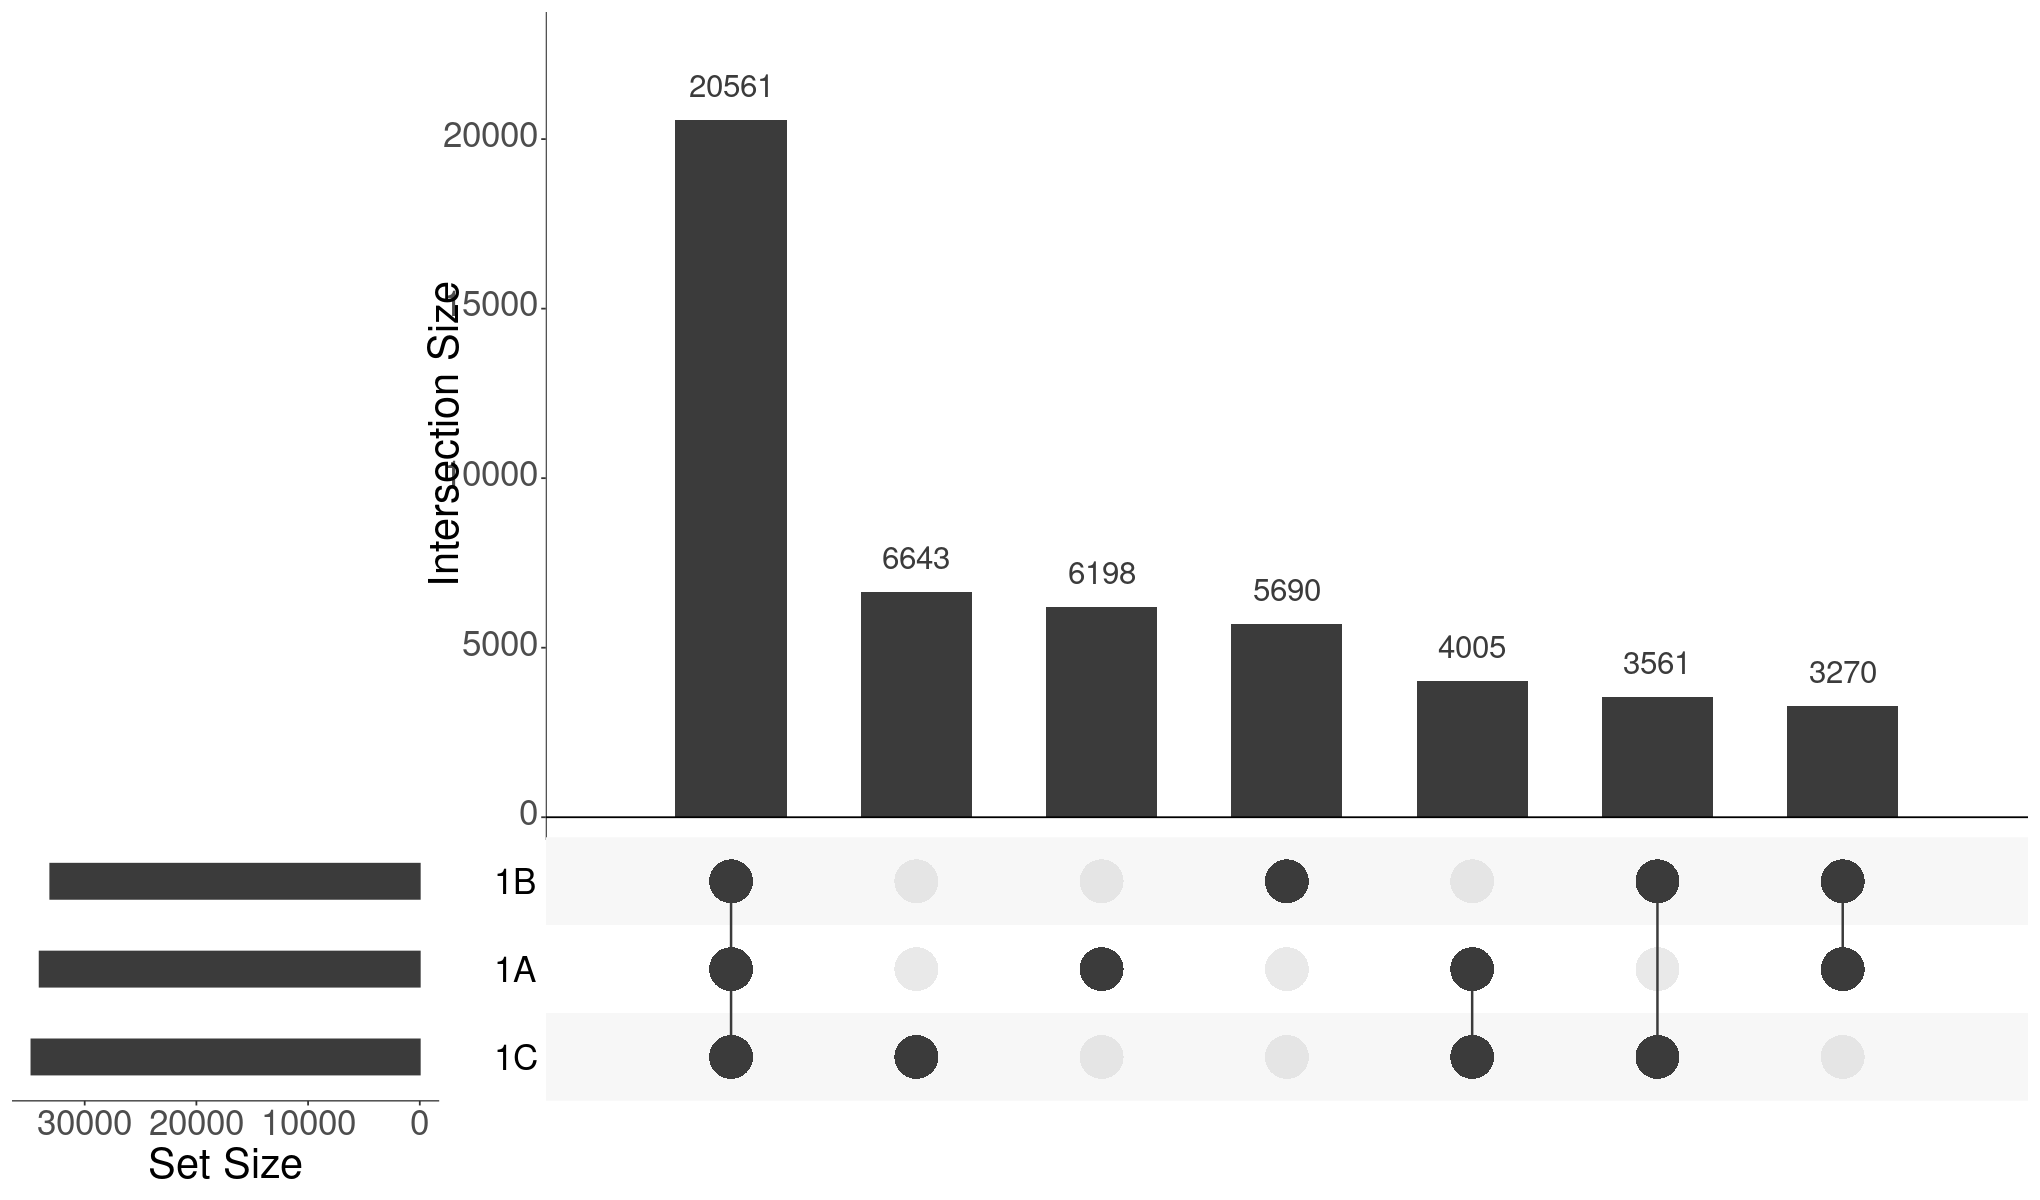

In [67]:
upset_input_example = upset_input[1:3]
options(repr.plot.width = 17, repr.plot.height = 10)
upset(fromList(upset_input_example),
      order.by = "freq",
      nsets = 13, text.scale = 3, point.size = 12) 

Considering samples 1A, 1B, and 1C, there are seven options for each barcode. It might be in all samples, only one sample, or more than one but not all. We can count up the number of barcodes in each of these categories, where each sample is a row whose sum is shown in the horizontal left bars, while each column is a non-overlapping barcode set detected in those samples with black dots.

Now, let's see what it looks like for all samples, including or excluding the barcode map:

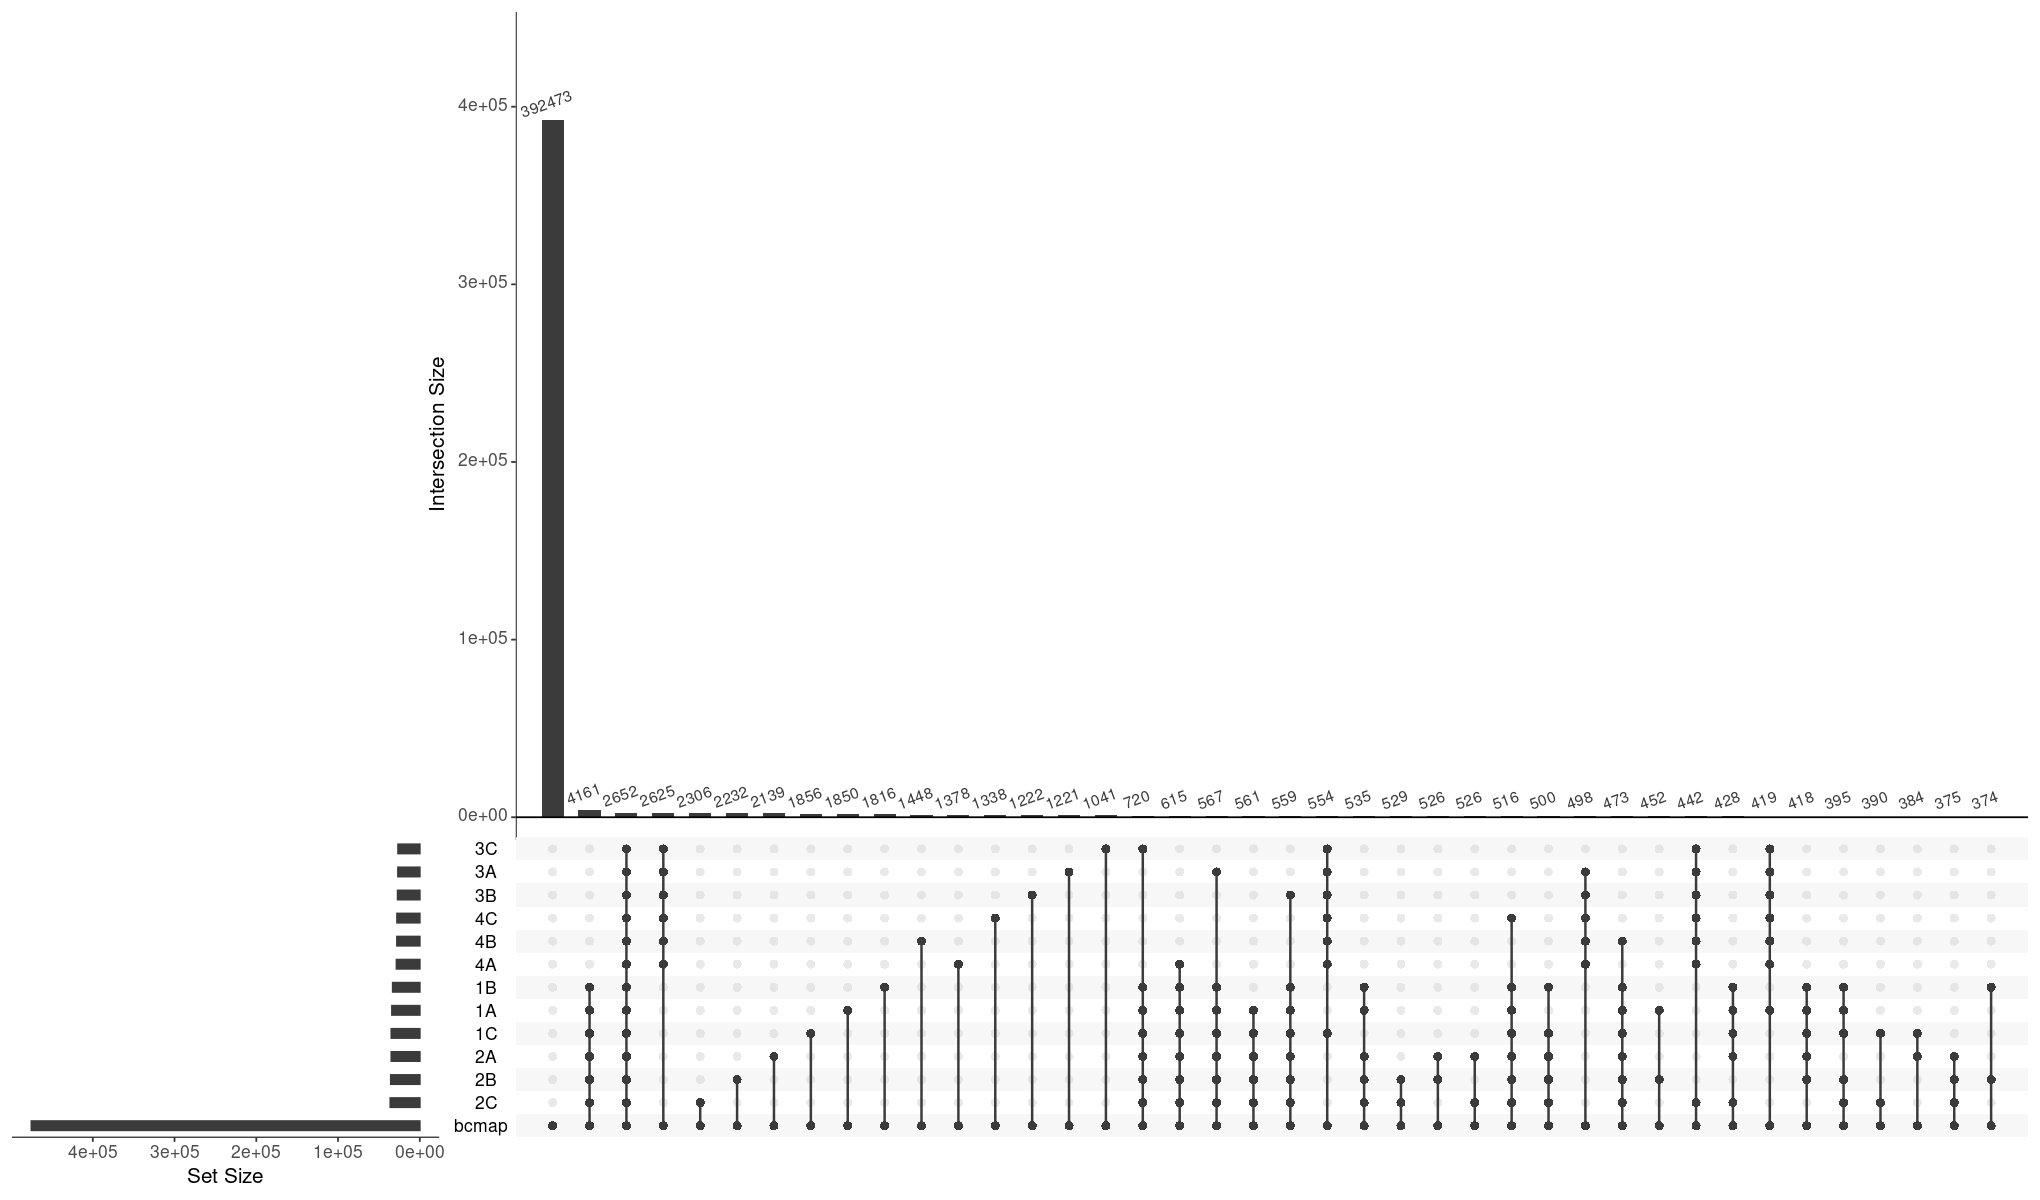

In [33]:
options(repr.plot.width = 17, repr.plot.height = 10)
upset(fromList(upset_input),
      order.by = "freq",
      nsets = 13, number.angle = 20, text.scale = 1.5) 

This is hard to see, so we can remove the "bcmap" set and just view the rest:

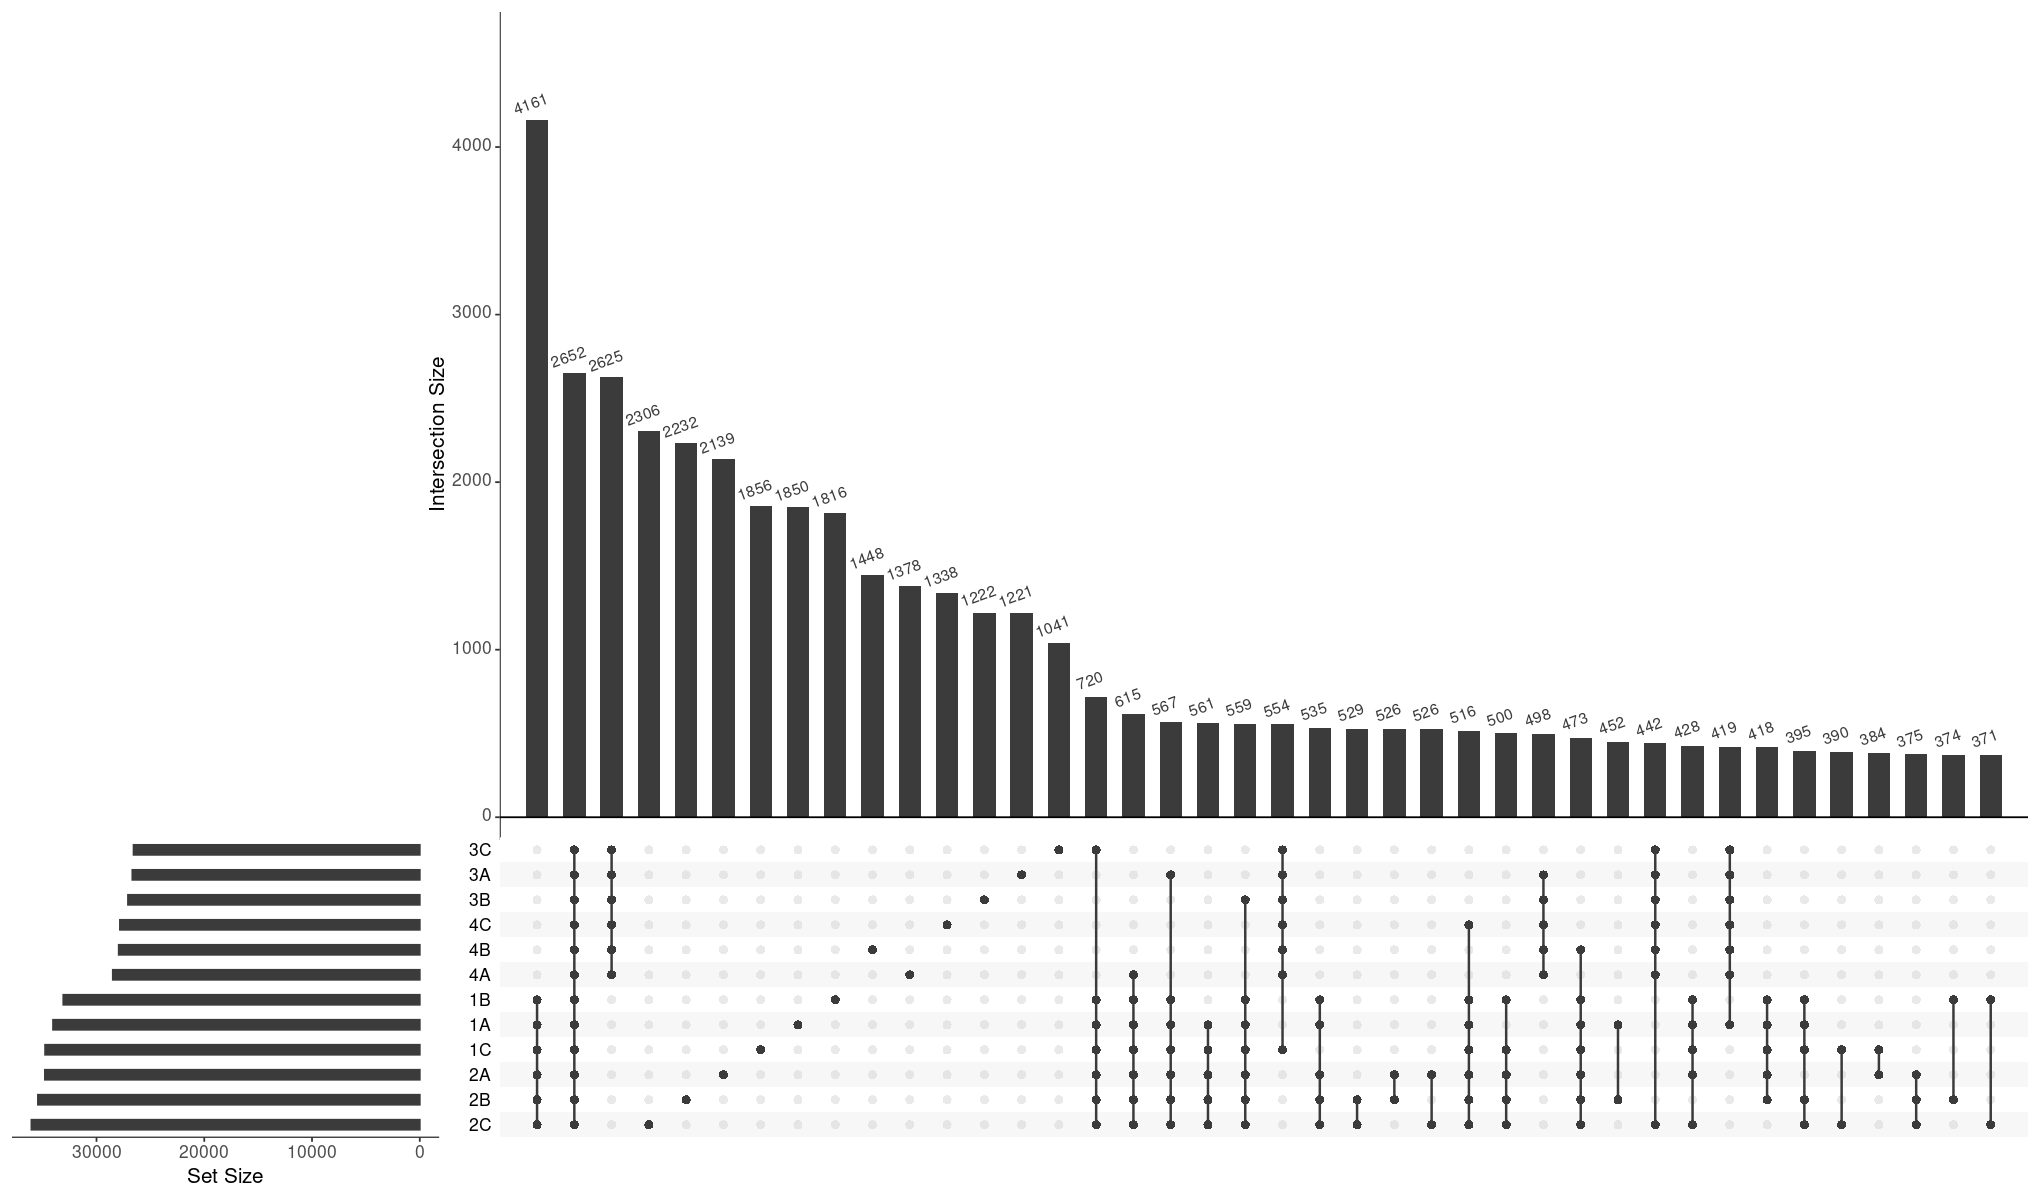

In [28]:
options(repr.plot.width = 17, repr.plot.height = 10)
upset(fromList(upset_input),
      order.by = "freq",
      nsets = 13, number.angle = 20, text.scale = 1.5) 

It immediately shows that most variants from barcode mapping are never seen again, but those that are seen again are a mix of those shared across all samples (both clones), those restricted to only one clone, and those that are specific to one or a handful of samples:

### Downsampling Results and Interpretation <a name="part4"></a>

We can re-sample this test dataset in a very large number of ways:

- [Unweighted Resampling](#partA)
- [Expression-Weighted Resampling](#partB)
- [Mapping-Weighted Resampling](#partC)

The easiest way to understand how this works is a simple diagram. Imagine there are a few reads that have the following counts in barcode mapping and expression:

| Barcode    | Mapping Count | Expression Count |
| ---------- | ----------- | ----------- |  
| AACAAGTCTATATTCAATATT   | 5       | 15 | 
| TTTGTGTTTGTGTTTATCAAA   | 10        | 5 |  
| ... | ... | ... |

  -  In Unweighted resampling, we randomly select with replacement from the `Expression Count` column some number of times, where each row has the same probability of selection.
  -  In Mapping-Weighted resampling, each row has a probability of selection proportional to the `Mapping Count`
  -  In Expression-Weighted resampling, each row has a probability of selection proportional to the `Expression Count`


#### Unweighted Resampling <a name="partA"></a>

We consider the vector of barcode expression counts across all samples, and resample these counts evenly such that any count has an equal probability of being sampled, with no other modifications (yet). We then compute summary statistics and plot their distributions stratified by resampling size:

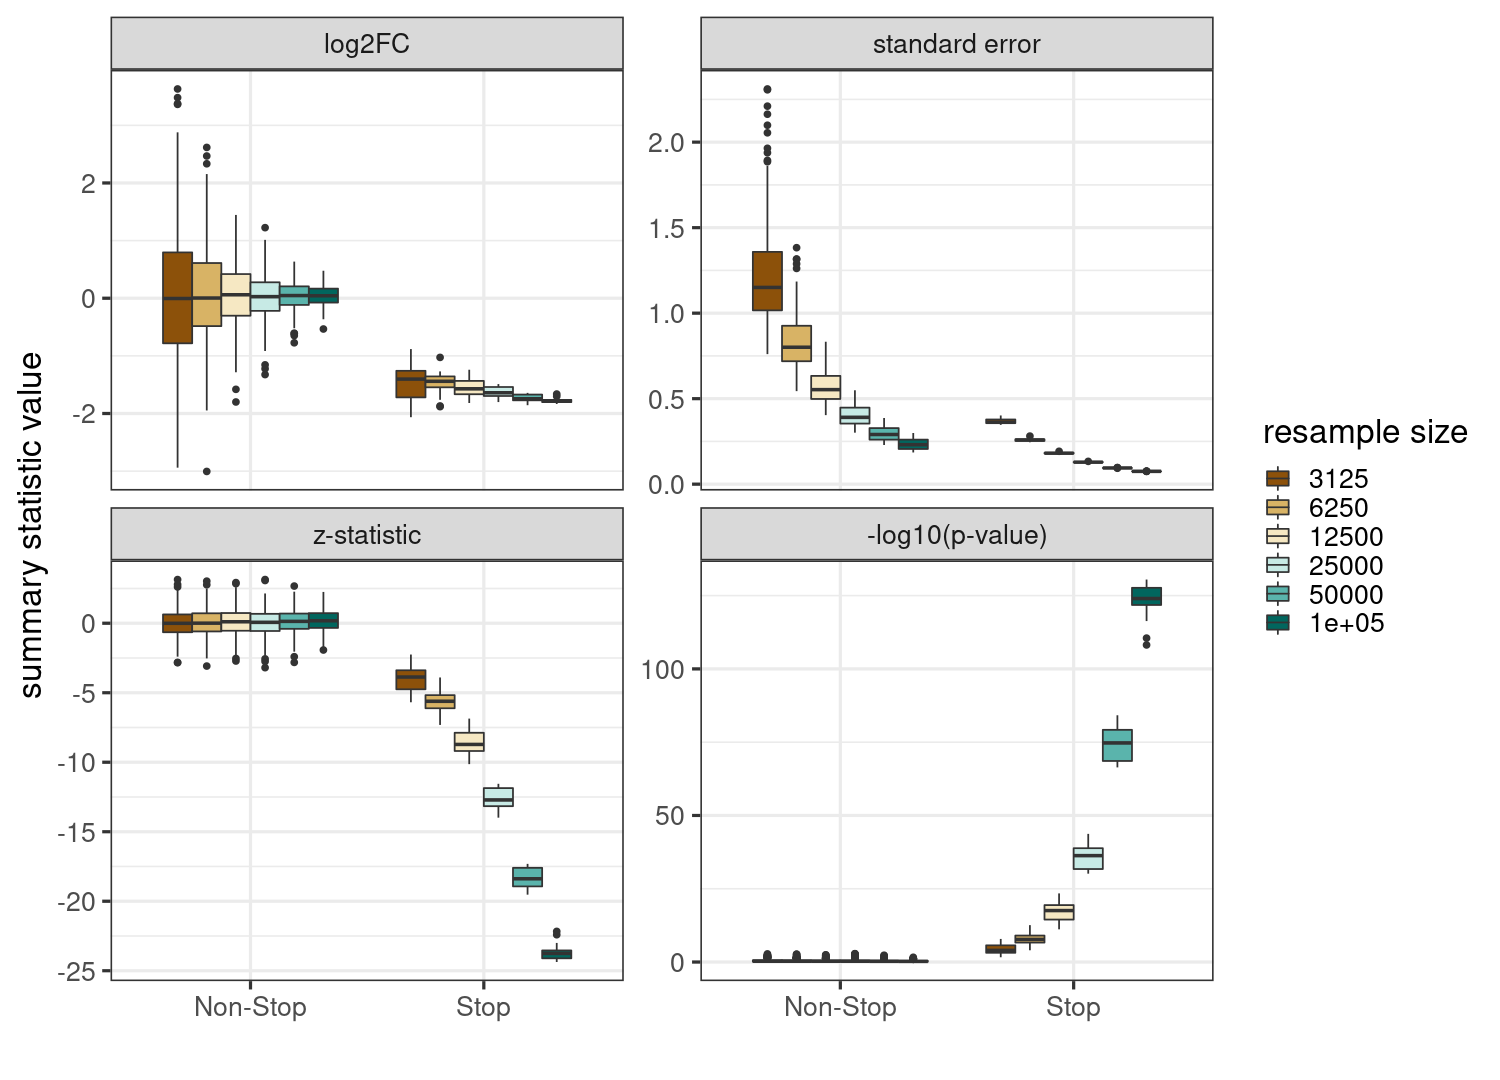

In [18]:
resamp_coefs_unweight <- dir_ls("../coefs-init/", glob = ("*resampling-coefs*tsv"))
names(resamp_coefs_unweight) <- gsub("../coefs-init/resampling-coefs-unweighted-|.tsv", "", resamp_coefs_unweight)
resamp_coefs_unweight <- resamp_coefs_unweight %>% map_dfr(read_tsv, .id = "sampsize", show_col_types = FALSE)

options(repr.plot.width = 12.5, repr.plot.height = 9) 
resamp_coefs_unweight %>%
    mutate(sampsize = factor(sampsize, levels = sort(as.numeric(unique(sampsize)))),
           group = if_else(mut_aa == "*", "Stop", "Non-Stop"),
           p.value = -log10(p.value),
           estimate = estimate / log(2),
           std.error = std.error / log(2)) %>%
    rename("log2FC" = "estimate",
           "standard error" = "std.error",
           "z-statistic" = "statistic",
           "-log10(p-value)" = "p.value",
           "resample size" = "sampsize") %>%
    pivot_longer(names_to = "stat", values_to = "value", log2FC:`-log10(p-value)`) %>% 
    mutate(stat = factor(stat, levels = c("log2FC", "standard error", "z-statistic", "-log10(p-value)"))) %>%
    ggplot() +
        geom_boxplot(aes(x = group, y = value, fill = `resample size`), position="dodge") +
        theme_bw(base_size = 20) +
        facet_wrap(~stat, scales = "free_y") +
        xlab("") + ylab("summary statistic value") +
        scale_fill_brewer(palette="BrBG")
    

#### Expression-Weighted Resampling <a name="partB"></a>

The simplest way to weight each barcode count is according to the normalized count frequency itself. So, barcode counts that are larger are proportionally more likely to be sampled than those that are smaller. This has a visible but relatively small effect on the resulting summary statistics:

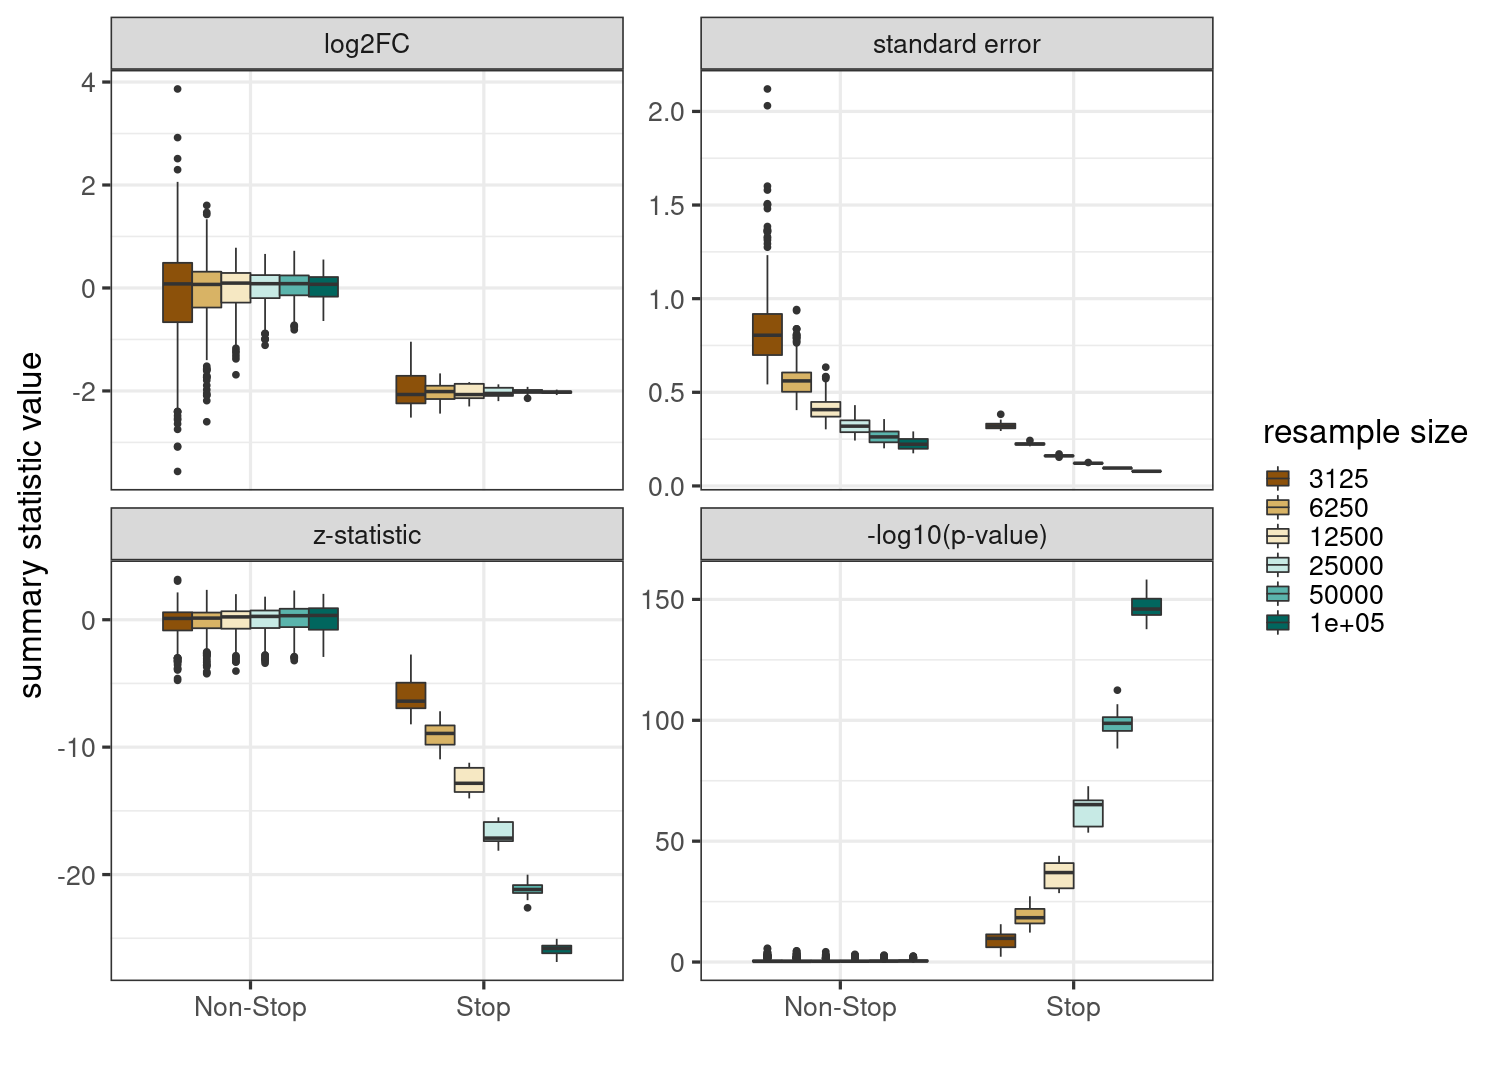

In [21]:
resamp_coefs_weight <- dir_ls("../coefs-weight/", glob = ("*resampling-coefs*tsv"))
names(resamp_coefs_weight) <- gsub("../coefs-weight/resampling-coefs-weighted-|.tsv", "", resamp_coefs_weight)
resamp_coefs_weight <- resamp_coefs_weight %>% map_dfr(read_tsv, .id = "sampsize", show_col_types = FALSE)

options(repr.plot.width = 12.5, repr.plot.height = 9) 
resamp_coefs_weight %>%
    mutate(sampsize = factor(sampsize, levels = sort(as.numeric(unique(sampsize)))),
           group = if_else(mut_aa == "*", "Stop", "Non-Stop"),
           p.value = -log10(p.value),
           estimate = estimate / log(2),
           std.error = std.error / log(2)) %>%
    rename("log2FC" = "estimate",
           "standard error" = "std.error",
           "z-statistic" = "statistic",
           "-log10(p-value)" = "p.value",
           "resample size" = "sampsize") %>%
    pivot_longer(names_to = "stat", values_to = "value", log2FC:`-log10(p-value)`) %>% 
    mutate(stat = factor(stat, levels = c("log2FC", "standard error", "z-statistic", "-log10(p-value)"))) %>%
    ggplot() +
        geom_boxplot(aes(x = group, y = value, fill = `resample size`), position="dodge") +
        theme_bw(base_size = 20) +
        facet_wrap(~stat, scales = "free_y") +
        xlab("") + ylab("summary statistic value") +
        scale_fill_brewer(palette="BrBG")
    

#### Mapping-Weighted Resampling <a name="partC"></a>

Alternatively, we can specify the probability of each barcode count being included as proportional to its frequency during _barcode mapping_ rather than expression itself. This may better model the experimental schematic shown at the start of this document, where many of the bottlenecking and cell sampling steps are in between barcode mapping and expression. We can retrieve these frequencies from the barcode mapping data and examine them:

In [62]:
bcs1 <- read_tsv("../pipeline/10A.bcmap-filtered-sub.tsv", col_names = FALSE) %>%
    filter(X5 >= 3, X7 >= 3, X6 >= 0.75, X8 >= 0.75) %>%
    mutate(group = "setA") %>% select(-X3, -X4, -X9, -X2)
bcs2 <- read_tsv("../pipeline/10B.bcmap-filtered-sub.tsv", col_names = FALSE) %>%
    filter(X5 >= 3, X7 >= 3, X6 >= 0.75, X8 >= 0.75) %>%
    mutate(group = "setB") %>% select(-X3, -X4, -X9, -X2)

bcs <- bind_rows(bcs1, bcs2) 

resample_counts <- read_tsv("../pipeline/resampling-counts.tsv") %>%
    left_join(bcs, by = c("barcode" = "X1")) %>%
    rename("rep1_count" = "X5",
           "rep1_purity" = "X6",
           "rep2_count" = "X7",
           "rep2_purity" = "X8")

write_tsv(resample_counts, "../pipeline/resampling-counts-mapfreq.tsv")

Rows: 33521 Columns: 9

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): X1, X2, X3
dbl (4): X5, X6, X7, X8
lgl (2): X4, X9


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 29297 Columns: 9

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): X1, X2, X3
dbl (4): X5, X6, X7, X8
lgl (2): X4, X9


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 208151 Columns: 15

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, condition...
dbl (6): count, chunk, pos, dox, condition_conc, total_counts


ℹ Use `spec()` to retrieve the full column specification 

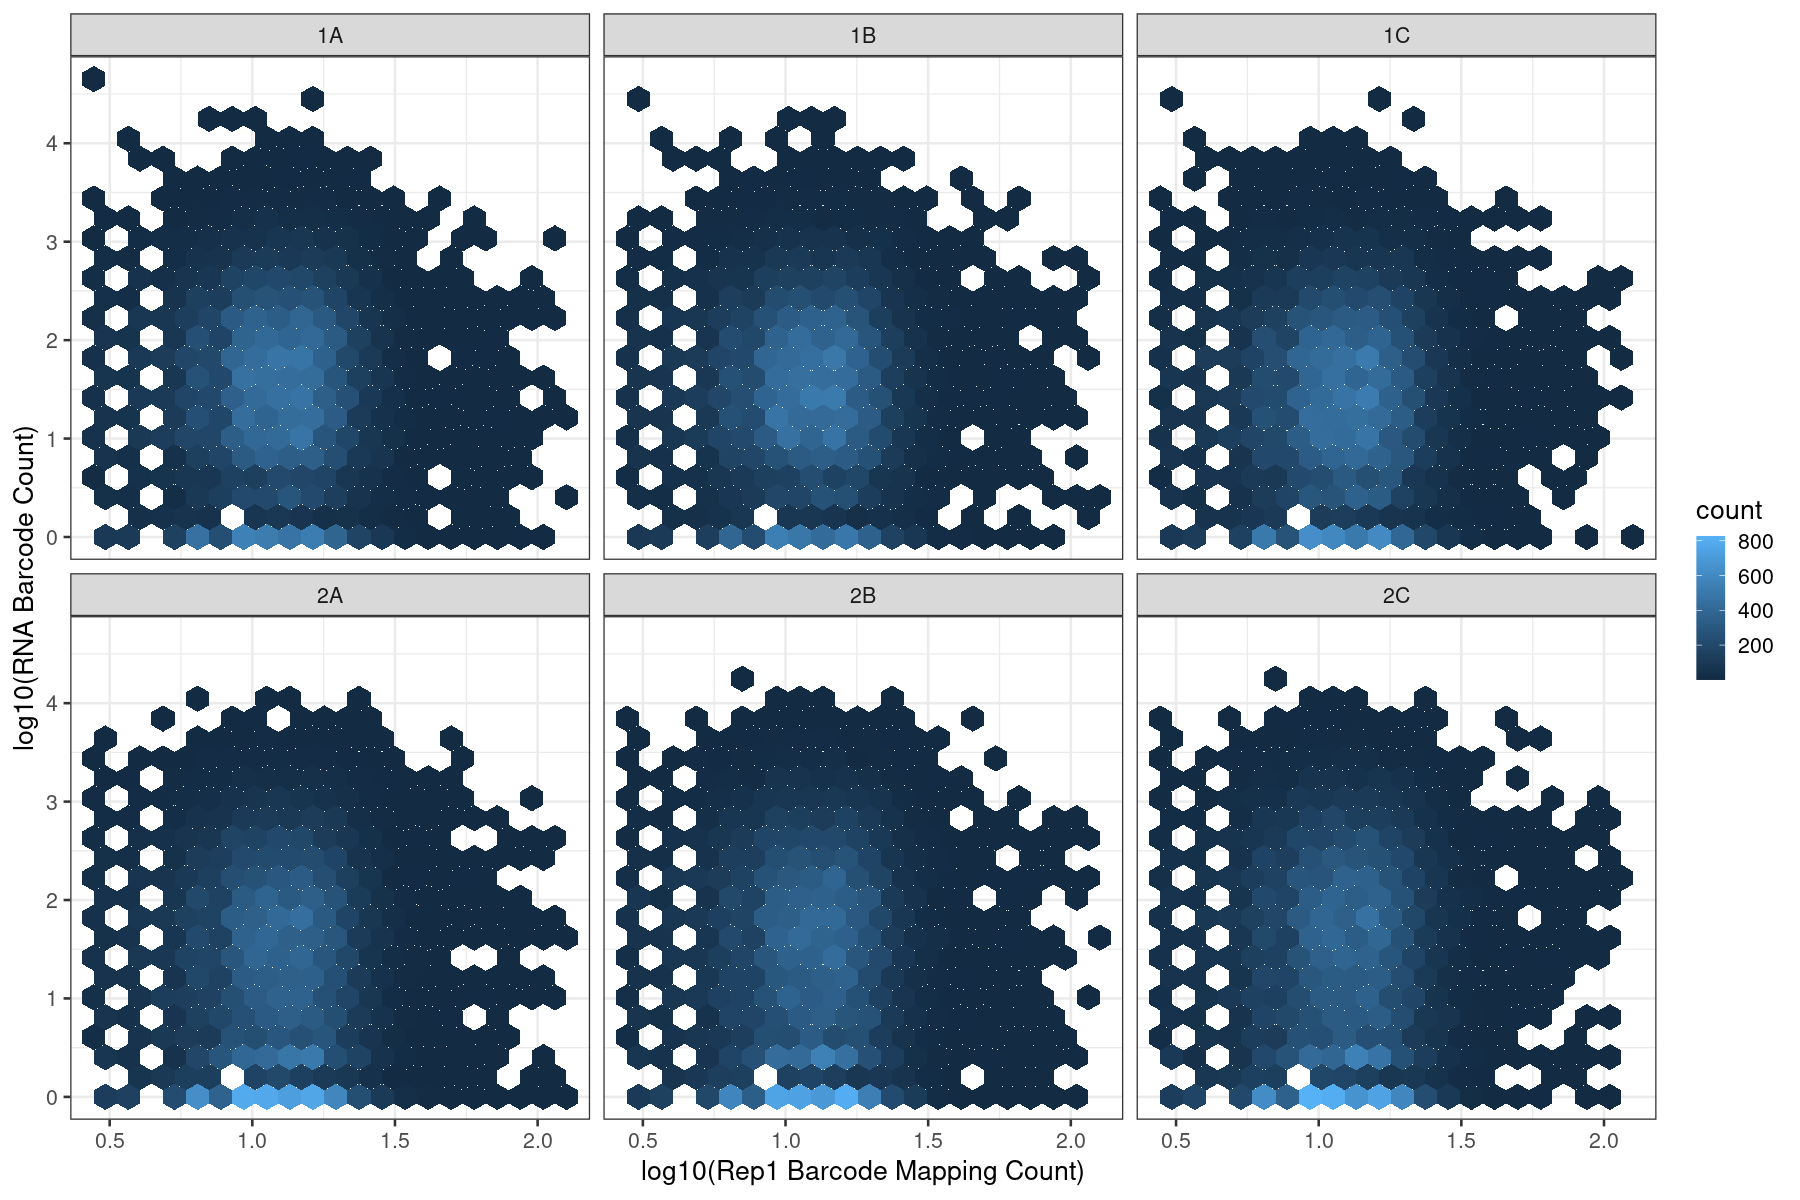

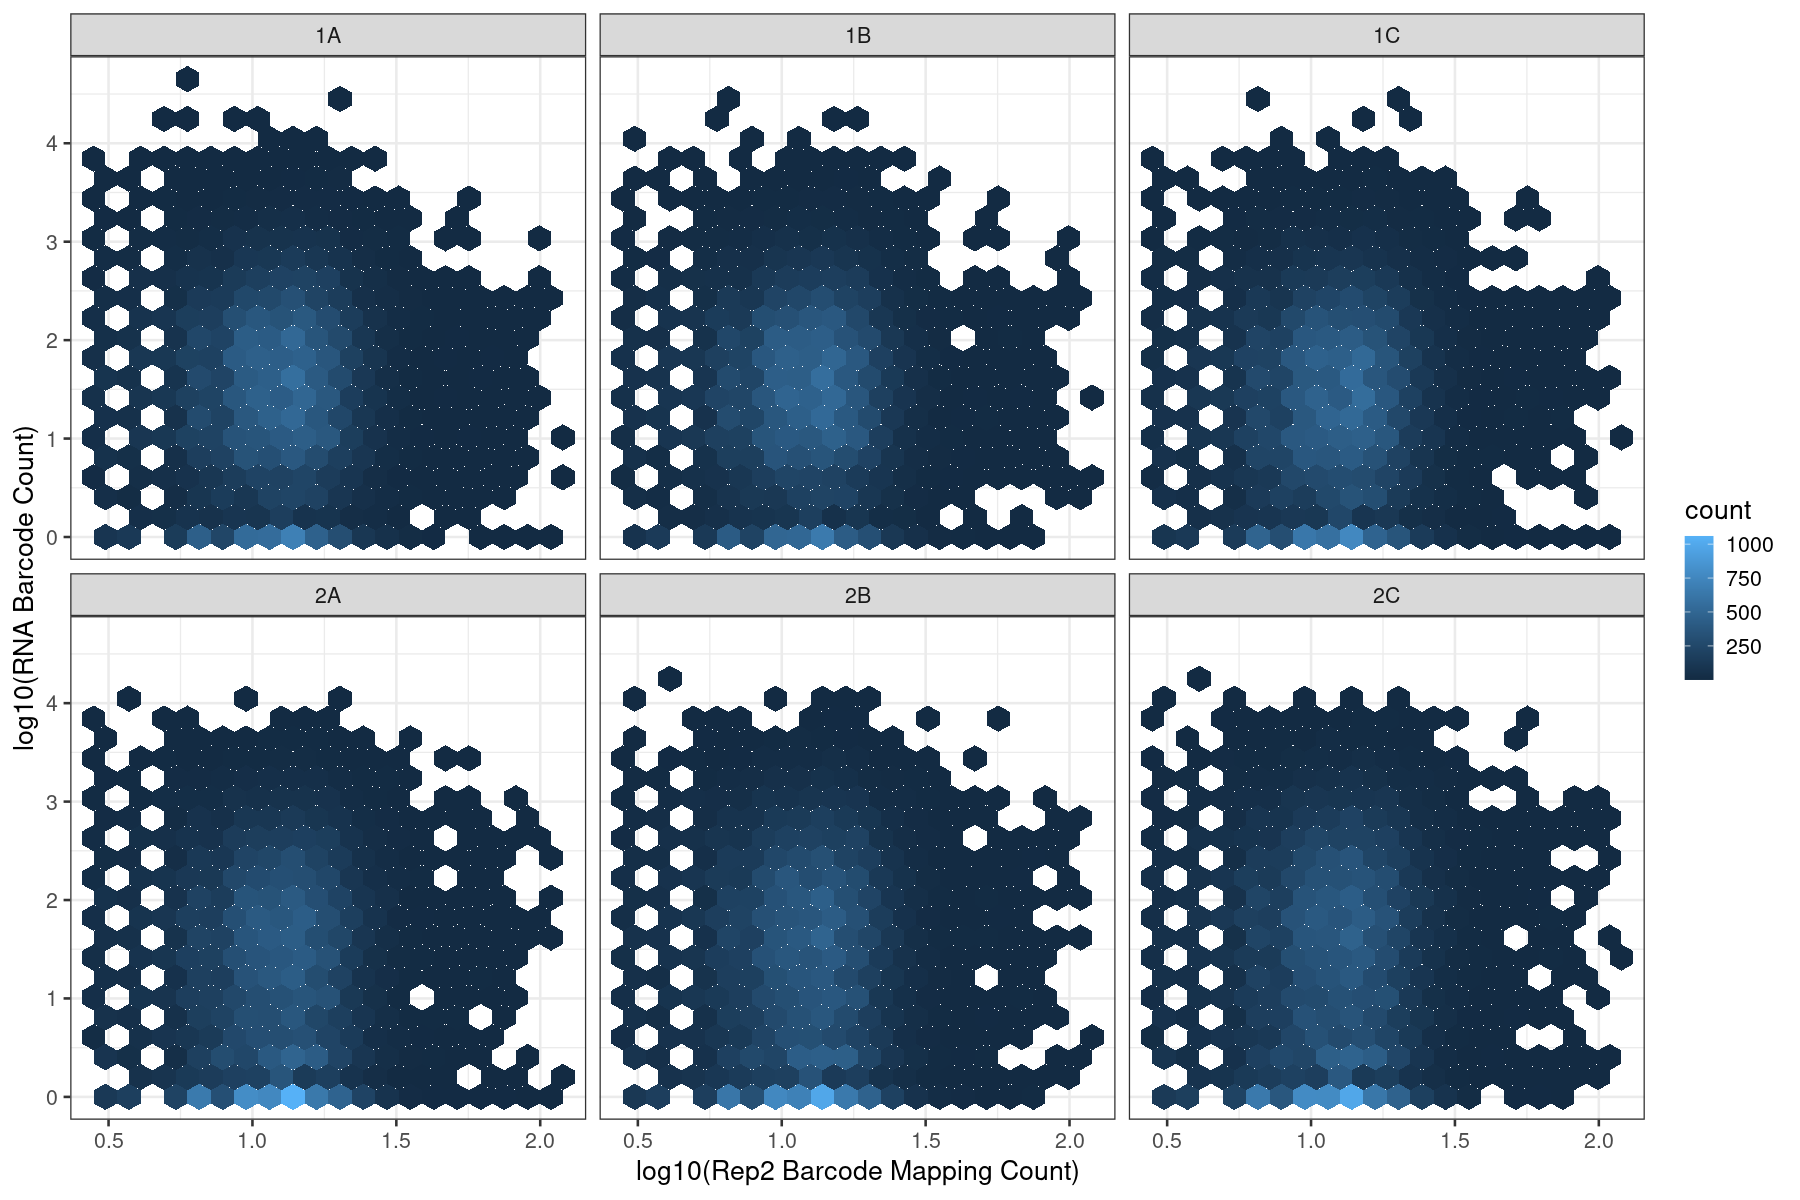

In [14]:
resample_counts <- read_tsv("../pipeline/resampling-counts-mapfreq.tsv", show_col_types = FALSE)
options(repr.plot.width = 15, repr.plot.height = 10)
resample_counts %>%
    ggplot() +
        geom_hex(aes(x = log10(rep1_count), y = log10(count)), bins = 20) +
        theme_bw(base_size = 16) +
        facet_wrap(~sample) +
        xlab("log10(Rep1 Barcode Mapping Count)") +
        ylab("log10(RNA Barcode Count)")
resample_counts %>%
    ggplot() +
        geom_hex(aes(x = log10(rep2_count), y = log10(count)), bins = 20) +
        theme_bw(base_size = 16) +
        facet_wrap(~sample) +
        xlab("log10(Rep2 Barcode Mapping Count)") +
        ylab("log10(RNA Barcode Count)")

They look pretty uncorrelated - to see what the sampling effects of using the barcode mapping count are likely to be, we can look at the one-dimensional distributions. The red lines below indicate read counts of 8 and 16. Those are the boundaries of the middle 50% of barcode frequencies from mapping for each sample, and there are no absurd outliers at the barcode-mapping level. So, we might expect this to be pretty similar to uniform sampling:

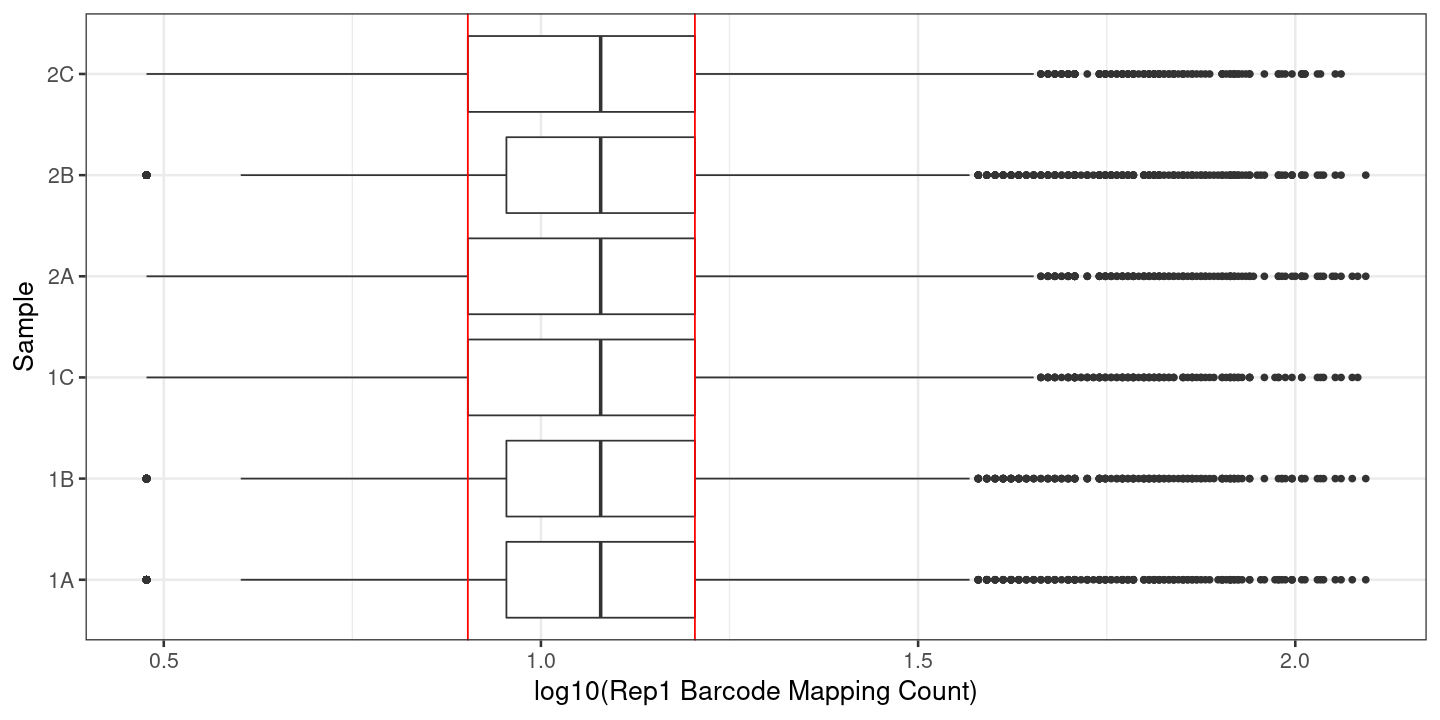

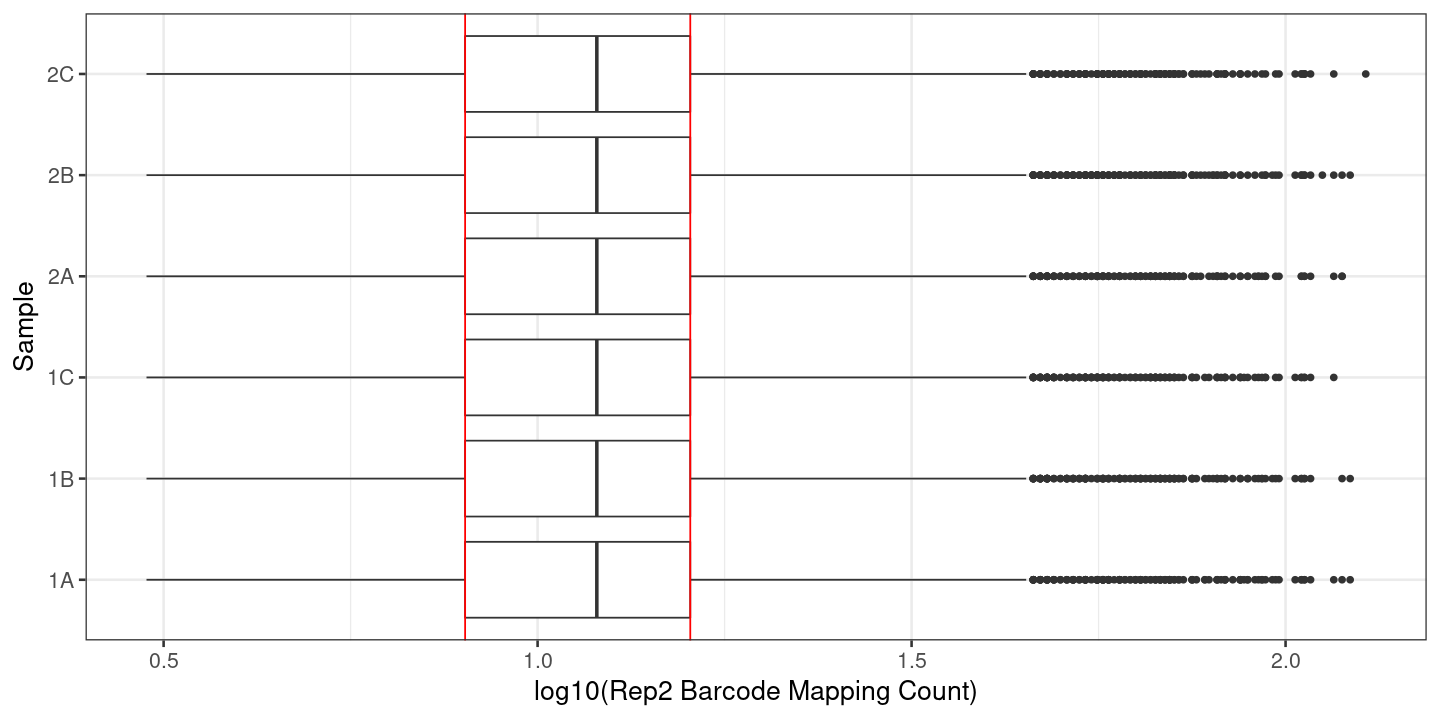

In [7]:
options(repr.plot.width = 12, repr.plot.height = 6)
resample_counts %>%
    ggplot() +
        geom_boxplot(aes(y = sample, x = log10(rep1_count))) +
        theme_bw(base_size = 16) +
        ylab("Sample") +
        xlab("log10(Rep1 Barcode Mapping Count)") +
        geom_vline(xintercept = c(log10(8), log10(16)), color = "red")
resample_counts %>%
    ggplot() +
        geom_boxplot(aes(y = sample, x = log10(rep2_count))) +
        theme_bw(base_size = 16) +
        ylab("Sample") +
        xlab("log10(Rep2 Barcode Mapping Count)") +
        geom_vline(xintercept = c(log10(8), log10(16)), color = "red")

Indeed, the summary statistic distributions by resampling size look pretty similar to those that came before:

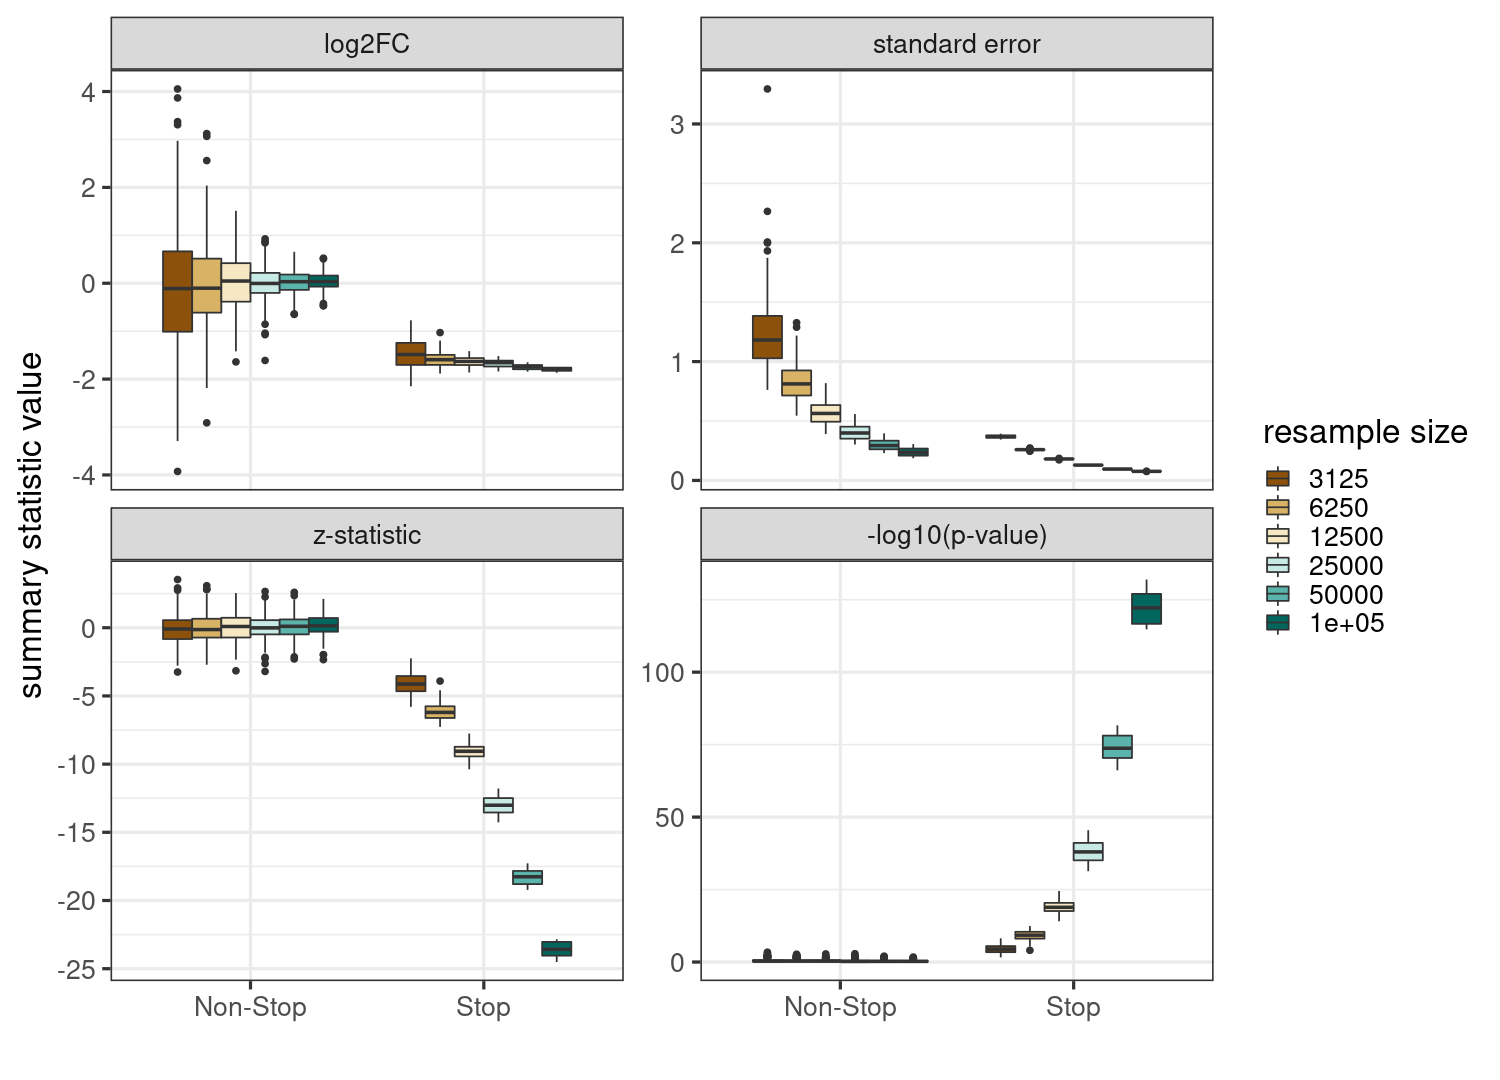

In [23]:
resamp_coefs_mappingweight <- dir_ls("../coefs-weight-bcmap/", glob = ("*resampling-coefs*tsv"))
names(resamp_coefs_mappingweight) <- gsub("../coefs-weight-bcmap/resampling-coefs-weighted-bcmap-|.tsv", "", resamp_coefs_mappingweight)
resamp_coefs_mappingweight <- resamp_coefs_mappingweight %>% map_dfr(read_tsv, .id = "sampsize", show_col_types = FALSE)

options(repr.plot.width = 12.5, repr.plot.height = 9) 
resamp_coefs_mappingweight %>%
    mutate(sampsize = factor(sampsize, levels = sort(as.numeric(unique(sampsize)))),
           group = if_else(mut_aa == "*", "Stop", "Non-Stop"),
           p.value = -log10(p.value),
           estimate = estimate / log(2),
           std.error = std.error / log(2)) %>%
    rename("log2FC" = "estimate",
           "standard error" = "std.error",
           "z-statistic" = "statistic",
           "-log10(p-value)" = "p.value",
           "resample size" = "sampsize") %>%
    pivot_longer(names_to = "stat", values_to = "value", log2FC:`-log10(p-value)`) %>% 
    mutate(stat = factor(stat, levels = c("log2FC", "standard error", "z-statistic", "-log10(p-value)"))) %>%
    ggplot() +
        geom_boxplot(aes(x = group, y = value, fill = `resample size`), position="dodge") +
        theme_bw(base_size = 20) +
        facet_wrap(~stat, scales = "free_y") +
        xlab("") + ylab("summary statistic value") +
        scale_fill_brewer(palette="BrBG")